# Big Data Bowl 2024
I wanted to do more with this project: build a model to predict probability of tackling and whatnot, but it required too much time that I didn't have to spare. Therefore, I made a simpler data analysis project out of this, with a task of answering the question: *Do high-performing athletes in the NFL have a remarkably different physical build compared to the benchwarmers?*

## Hypothesis
I thought that there wouldn't be too much of a difference as scouts and the combine seem to look for certain traits amongst players when they are drafted. But I was hoping to be pleasantly surprised. 

## Plan
In this notebook I merge dataframes supplied by the NFL to calculate a contribution efficiency statistic by summing tackles, assists and fumbles divided by possible tackles. I then split the dataframe into 2 to look at the top half and bottom half of performers physically. I visualized the differences by position side by side with Seaborn and Matplotlib, then proceeded to do a hypothesis test between the two populations. 

## Extra
Finally I wanted to add in some clustering to try and partition the players, I decided to focus on cornerbacks as they were one of the most populated positions in this dataframe. I used an elbow plot to identify clusters, used KMeans and then plotted results showing results. I then used [PFF's grading system](https://www.pff.com/news/nfl-cornerback-rankings-final-sauce-gardner-retains-his-place-as-the-no-1-cornerback-in-the-nfl) to start a search for which cluster contained the *premier* corner backs in the league. This led me to some cool insights and a thought that one could use this data as a predictor to find rising stars at the position. 

# Creating a tackling metric

In order to compare players, we need to have a metric first to compare them.

In [85]:
#Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats 
import sklearn
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore") 

In [86]:
tackles = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2024/tackles.csv") #Load dataframes
players = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2024/players.csv")
players_tackles = players.merge(tackles, on = 'nflId', how = "right") #Merge both dataframes

players_tackles[(players_tackles['tackle'] == 0) & (players_tackles['assist'] == 0) & (players_tackles['forcedFumble'] == 0) & (players_tackles['pff_missedTackle'] == 0)]
#Players either tackled, assisted on the tackle or forced a fumble OR they missed the tackle. I should add tackles, assist and forced fumbles, for tackle contributions, then add that number with missed tackles for total possible tackles

,nflId,height,weight,birthDate,collegeName,position,displayName,gameId,playId,tackle,assist,forcedFumble,pff_missedTackle


I use a right merge to collect defensive players, as they are the only ones included in the tackles df. The last line of code shows that players either contributed to a player or missed a tackle.

In [87]:
players_tackles.head()

,nflId,height,weight,birthDate,collegeName,position,displayName,gameId,playId,tackle,assist,forcedFumble,pff_missedTackle
0,42816,5-11,184,1991-08-29,Oregon,CB,Troy Hill,2022090800,101,1,0,0,0
1,46232,6-3,308,1997-07-11,Virginia Tech,DT,Tim Settle,2022090800,393,1,0,0,0
2,40166,6-0,191,1991-04-25,Oregon State,SS,Jordan Poyer,2022090800,486,1,0,0,0
3,47939,6-5,248,1996-01-15,Oregon,OLB,Justin Hollins,2022090800,646,1,0,0,0
4,40107,6-0,197,1990-12-31,Iowa,FS,Micah Hyde,2022090800,818,1,0,0,0


We have some redundant columns: nflId, birthDate and collegeName to name a few. There is also the issue of height being a string, we'll have to change that to a number variable later on. First we'll get to calculating a simple metric.

In [88]:
players_tackles['tackle_contribution'] = players_tackles['tackle'] + players_tackles['assist'] + players_tackles['forcedFumble']
players_tackles['tackle_contribution'].value_counts()

tackle_contribution
1    15314
0     2013
2       99
Name: count, dtype: int64

What I've done is combine a player's tackles, assists and fumbles into one stat. 2 means they forced a fumble in addition to tackling or assisting on the tackle, 1 is just one of those actions and 0 means they missed the tackle. 

In [89]:
players_tackles.drop(columns = ['tackle', 'assist','forcedFumble','birthDate', 'playId', 'gameId'], inplace = True)
players_tackles.reset_index(drop = True, inplace = True)
players_tackles

,nflId,height,weight,collegeName,position,displayName,pff_missedTackle,tackle_contribution
0,42816,5-11,184,Oregon,CB,Troy Hill,0,1
1,46232,6-3,308,Virginia Tech,DT,Tim Settle,0,1
2,40166,6-0,191,Oregon State,SS,Jordan Poyer,0,1
3,47939,6-5,248,Oregon,OLB,Justin Hollins,0,1
4,40107,6-0,197,Iowa,FS,Micah Hyde,0,1
...,...,...,...,...,...,...,...,...
17421,43533,6-4,215,Clemson,FS,Jayron Kearse,1,0
17422,42406,6-3,260,Michigan,DE,Frank Clark,1,0
17423,43478,5-11,196,Purdue,CB,Anthony Brown,1,0
17424,42431,6-5,252,Louisiana State,OLB,Danielle Hunter,1,0


We drop columns that have already been accounted for or are irrelevant to cumulative statistics. 

We will now make two dataframes to count total tackles and missed tackles that we will merge later on to calculate total possible tackles. 

In [90]:
missed_tackles = players_tackles.copy()
tackles_made = players_tackles.copy()

In [91]:
tackles_made = tackles_made.groupby(["displayName", "nflId", "height", "weight","collegeName", "position"])[['tackle_contribution']].sum().reset_index()
tackles_made.at[322,'position'] = 'FS' 

missed_tackles = missed_tackles.groupby(["displayName", "nflId", "height", "weight","collegeName", "position"])[['pff_missedTackle']].sum().reset_index()
missed_tackles.at[322,'position'] = 'FS' 

I edit row 322 because Isiah Simmons was the only person listed as a DB within the dataframe. On ESPN he is listed as a safety, therefore I switched him to FS. 

In [92]:
combined_tackles = tackles_made.merge(missed_tackles, on = ['displayName', 'nflId', 'height', 
                                                           'weight','collegeName', 'position'])

In [93]:
combined_tackles['total_plays'] = combined_tackles['tackle_contribution'] + combined_tackles['pff_missedTackle'] #Calculate total plays
combined_tackles['efficiency %'] = round(combined_tackles['tackle_contribution'] / combined_tackles['total_plays'],2) * 100 #Calculate contribution

In [94]:
combined_tackles['total_plays'].value_counts()

total_plays
1     51
2     39
3     31
4     29
10    28
      ..
74     1
78     1
80     1
58     1
77     1
Name: count, Length: 85, dtype: int64

Almost 200 players have less than or equal to 10 plays total. Let's sort by the number of tackles and separate the dataframe into a top and bottom half, to view players that contribute more. Keep in mind there are 9 weeks of data here, so less than 10 is averaging slightly over 1 tackle a game, which is bad for every position - we don't need to segment the dataframe based off position then.

In [95]:
sorted_df = combined_tackles.sort_values(by = ["total_plays", 'efficiency %'], ascending = False)
top_half = sorted_df.iloc[:400, :].reset_index(drop = True)
bot_half = sorted_df.iloc[400:, :].reset_index(drop = True)

We should now change the height to a numerical variable. 

In [96]:
def calc_height(row):
    return (int(row['height'].split("-")[0])*12) + int(row['height'].split("-")[1])
top_half['height'] = top_half.apply(calc_height, axis = 1)
bot_half['height'] = bot_half.apply(calc_height, axis = 1)

We can do visual analysis with this dataframe now and see how weight and height can impact efficiency.

In [97]:
defensive_positions = list(sorted_df['position'].unique()) #
defensive_positions

['ILB', 'OLB', 'SS', 'FS', 'CB', 'MLB', 'DT', 'DE', 'NT']

# Visualizing Physical Distributions

In [98]:
grouped_high = top_half.groupby("position").size().reset_index().rename({0 : "Count"}, axis = 1).sort_values(by = "Count", ascending = False).reset_index(drop = True)
grouped_low = bot_half.groupby("position").size().reset_index().rename({0 : "Count"}, axis = 1).sort_values(by = "Count", ascending = False).reset_index(drop = True)
both = grouped_high.merge(grouped_low, on = "position", suffixes = ("_high", "_low"))
both['total'] = both['Count_high'] + both['Count_low']

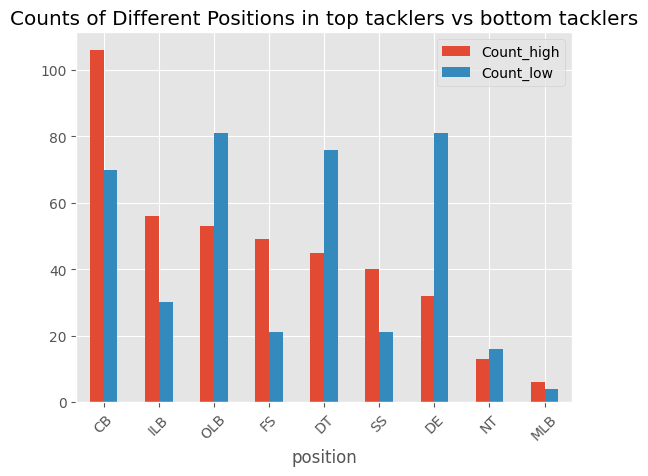

In [99]:
both.plot(x = "position", y = ["Count_high", "Count_low"], kind = "bar")
plt.title("Counts of Different Positions in top tacklers vs bottom tacklers")
plt.xticks(rotation = 45)
plt.show()

We can do a p-test on this to see if there's a significance to positions being separated. 

In [100]:
def z_score(a, b):
    num = a-b
    den = (a+b)**(1/2)
    return num / den
both['p_value'] = scipy.stats.norm.sf(abs(both.apply(lambda x: z_score(x['Count_high'], x['Count_low']), axis = 1)))
both.sort_values(by = "p_value")

,position,Count_high,Count_low,total,p_value
6,DE,32,81,113,0.000002
3,FS,49,21,70,0.000409
4,DT,45,76,121,0.002415
1,ILB,56,30,86,0.002526
0,CB,106,70,176,0.003328
5,SS,40,21,61,0.007493
2,OLB,53,81,134,0.007785
8,MLB,6,4,10,0.263545
7,NT,13,16,29,0.288734


The clear difference in skill between top and bottom performers lies within the defensive end position, free safety also has a clear significance as well. Positions such as MLB and NT seem to be fairly spread across either dataframe, but we could've seen that without the significance test. 

## Weight Differences

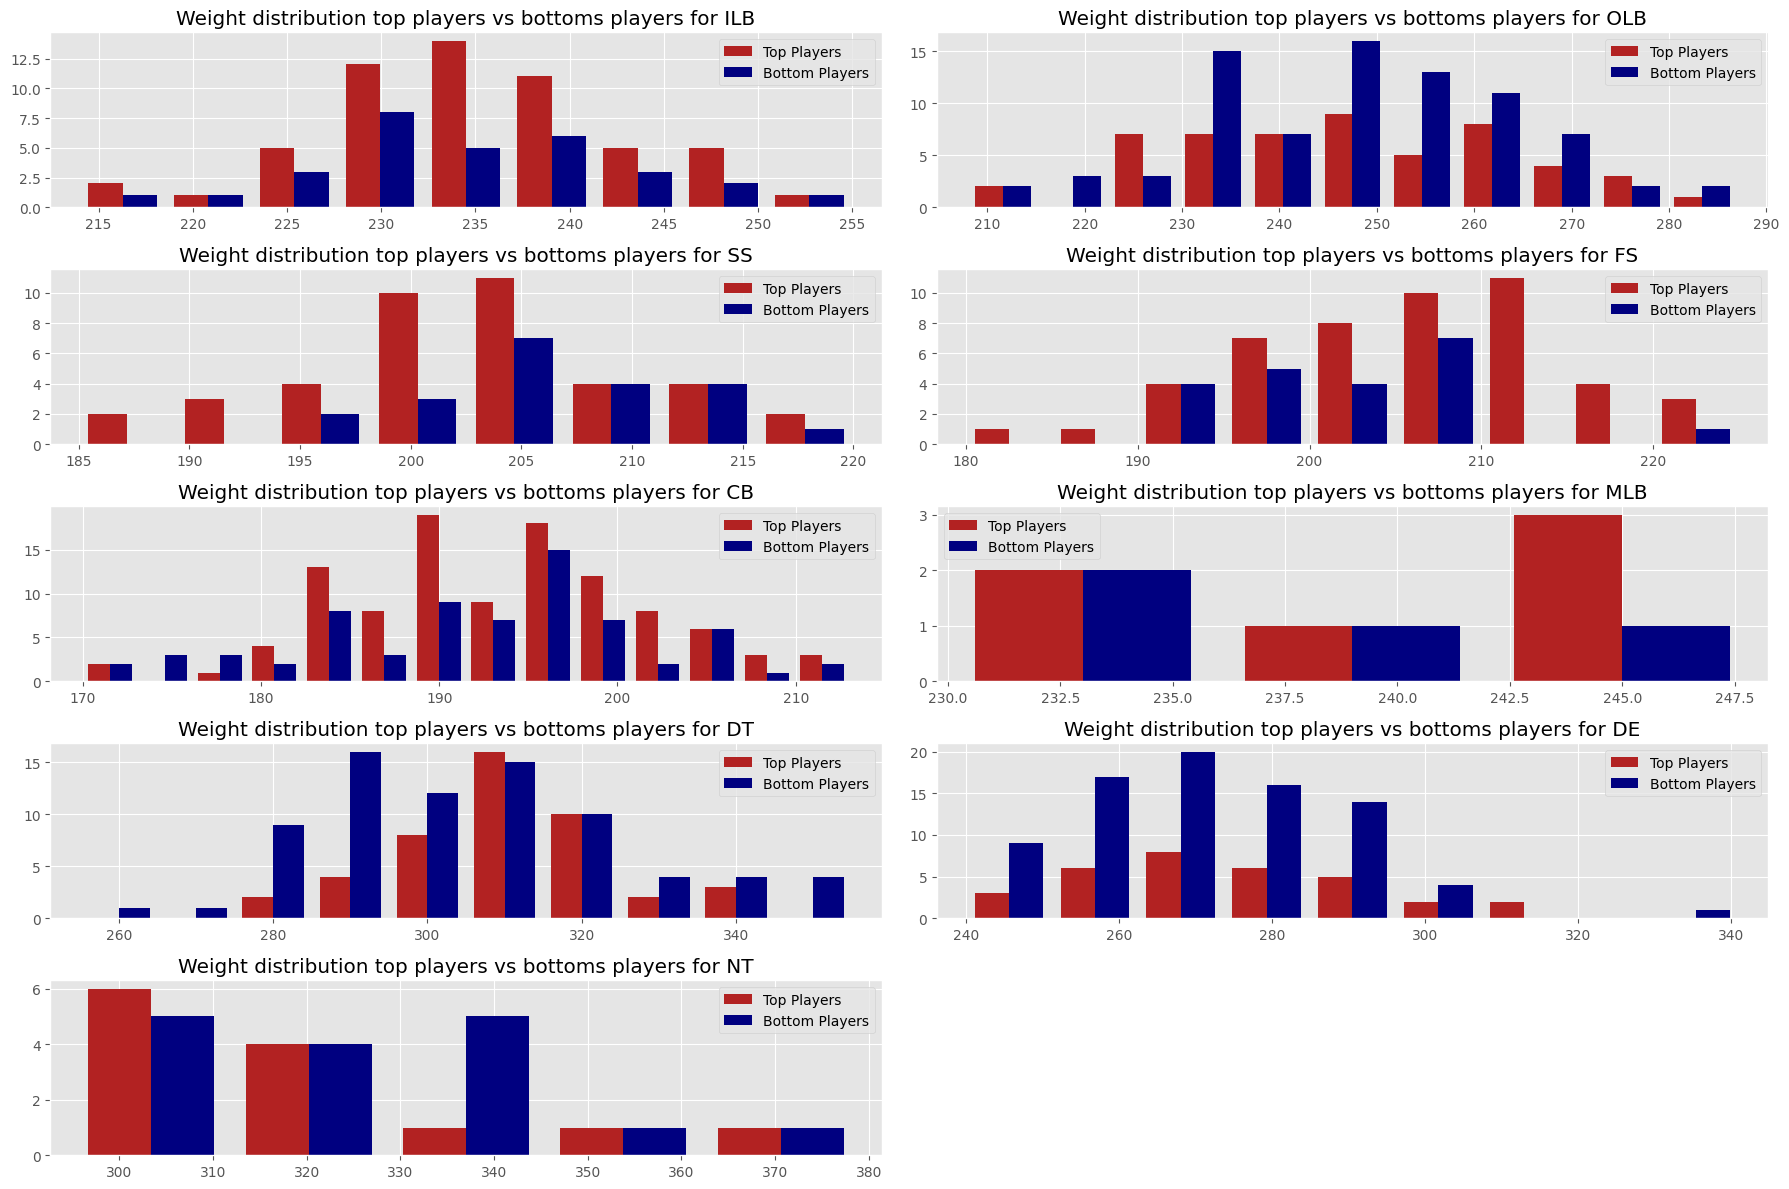

In [101]:
fig = plt.figure(figsize = (18,12))
plt.style.use("ggplot")
colors = ['firebrick', 'navy']
labels = ['Top Players', 'Bottom Players']
for idx, position in enumerate(defensive_positions):
    ax = fig.add_subplot(5,2,idx+1)
    top_df = top_half[top_half['position'] == position]
    bot_df = bot_half[bot_half['position'] == position]
    bins = int(int(top_df.shape[0] ** (1/2)) + int(bot_df.shape[0] ** (1/2))/2) #Take average of shapes, it's recommended that bins are the size of the df, square root of that and rounded up.
    plt.hist([top_df['weight'], bot_df['weight']], color = ['firebrick','navy'], bins = bins, label = ['Top Players', 'Bottom Players']) #Stacked histogram
    ax.legend()
    plt.title(f"Weight distribution top players vs bottoms players for {position.upper()}")
plt.tight_layout()
plt.show()

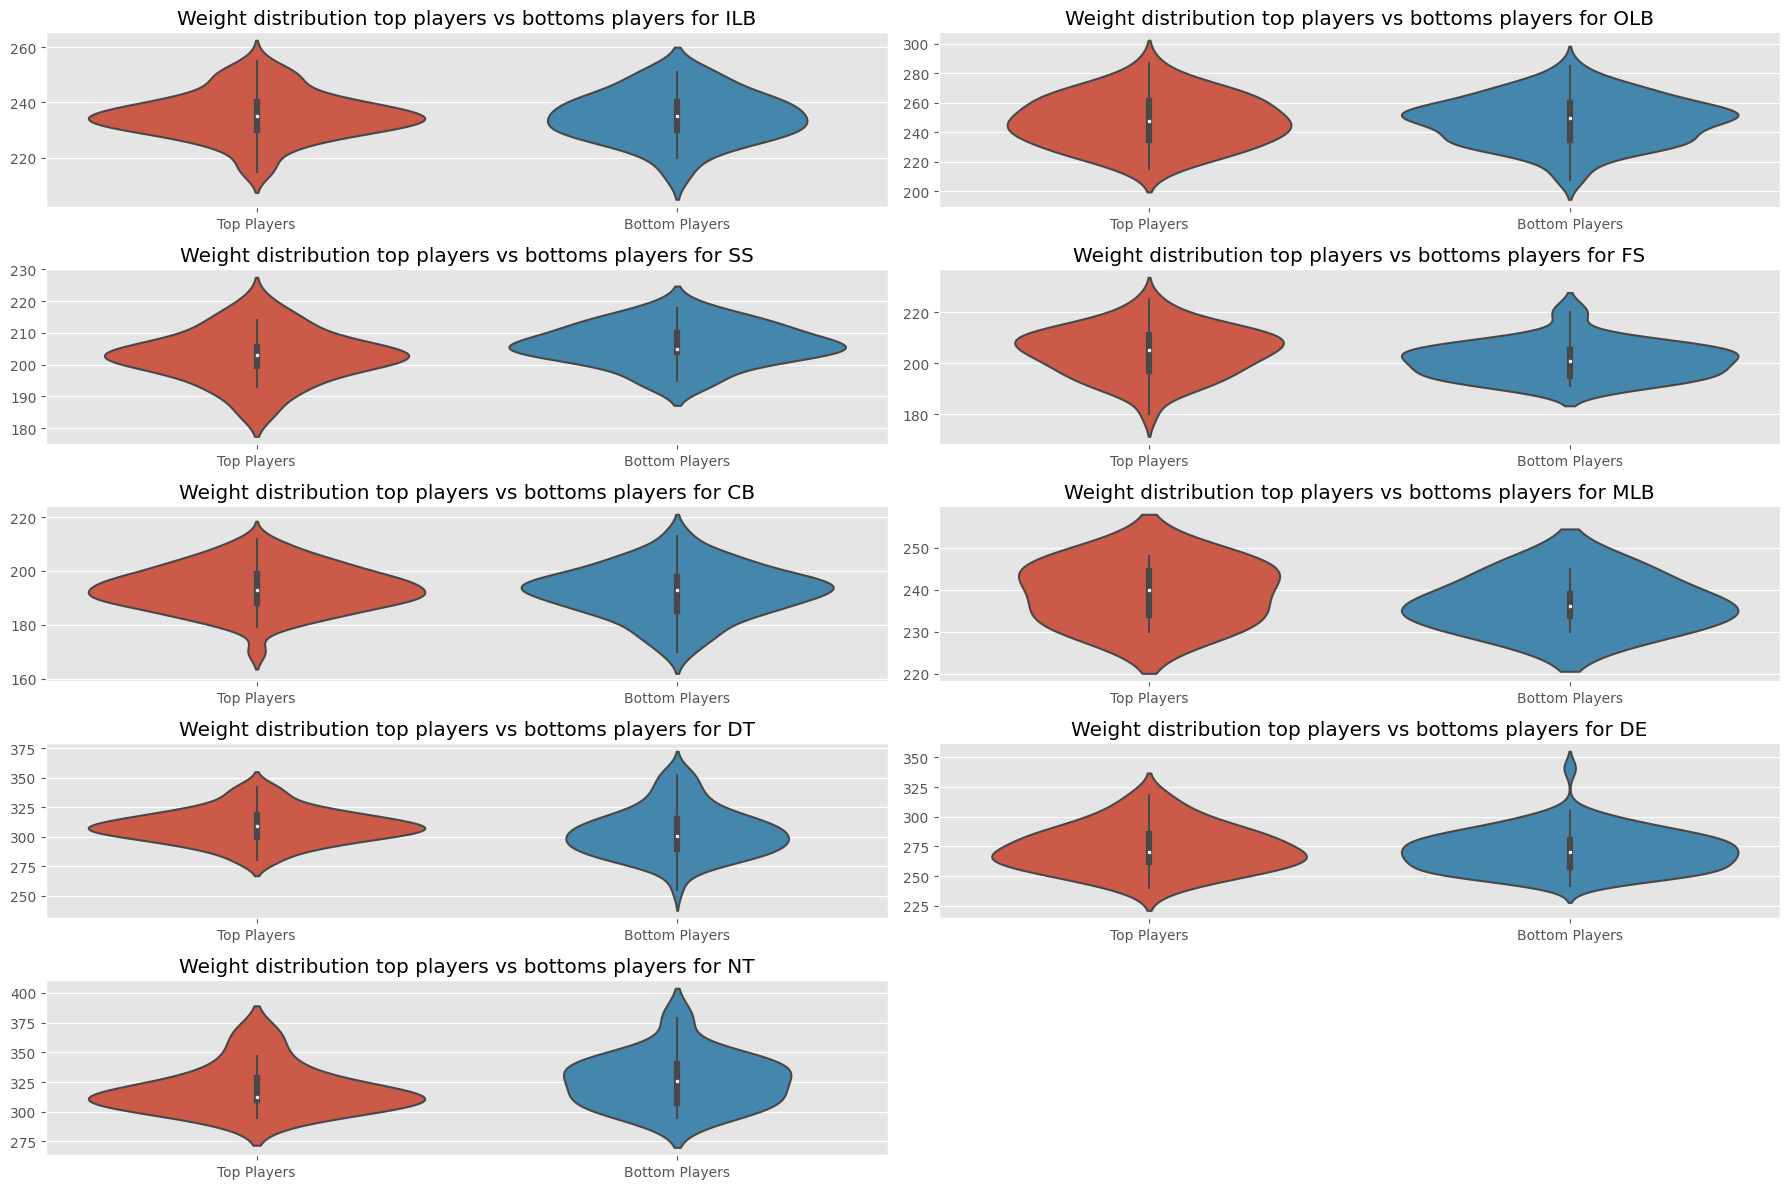

In [102]:
fig = plt.figure(figsize = (18,12))
plt.style.use("ggplot")
labels = ['Top Players', 'Bottom Players']
for idx, position in enumerate(defensive_positions):
    ax = fig.add_subplot(5,2,idx+1)
    top_df = top_half[top_half['position'] == position]
    bot_df = bot_half[bot_half['position'] == position]
    sns.violinplot([top_df['weight'], bot_df['weight']]) 
    plt.title(f"Weight distribution top players vs bottoms players for {position.upper()}")
    plt.xticks(ticks = [0,1], labels = labels)
plt.tight_layout()
plt.show()

This data doesn't indicate much in terms of difference. For positions with too low of count, such as MLB or NT, the sample size isn't reliable. Whereas for the positions that do have enough people, the distribution is quite similar. You can make a case that ILB and DT have compact populations, with a smaller range of values, but still the mean weight is pretty much the same. 

### Height Differences

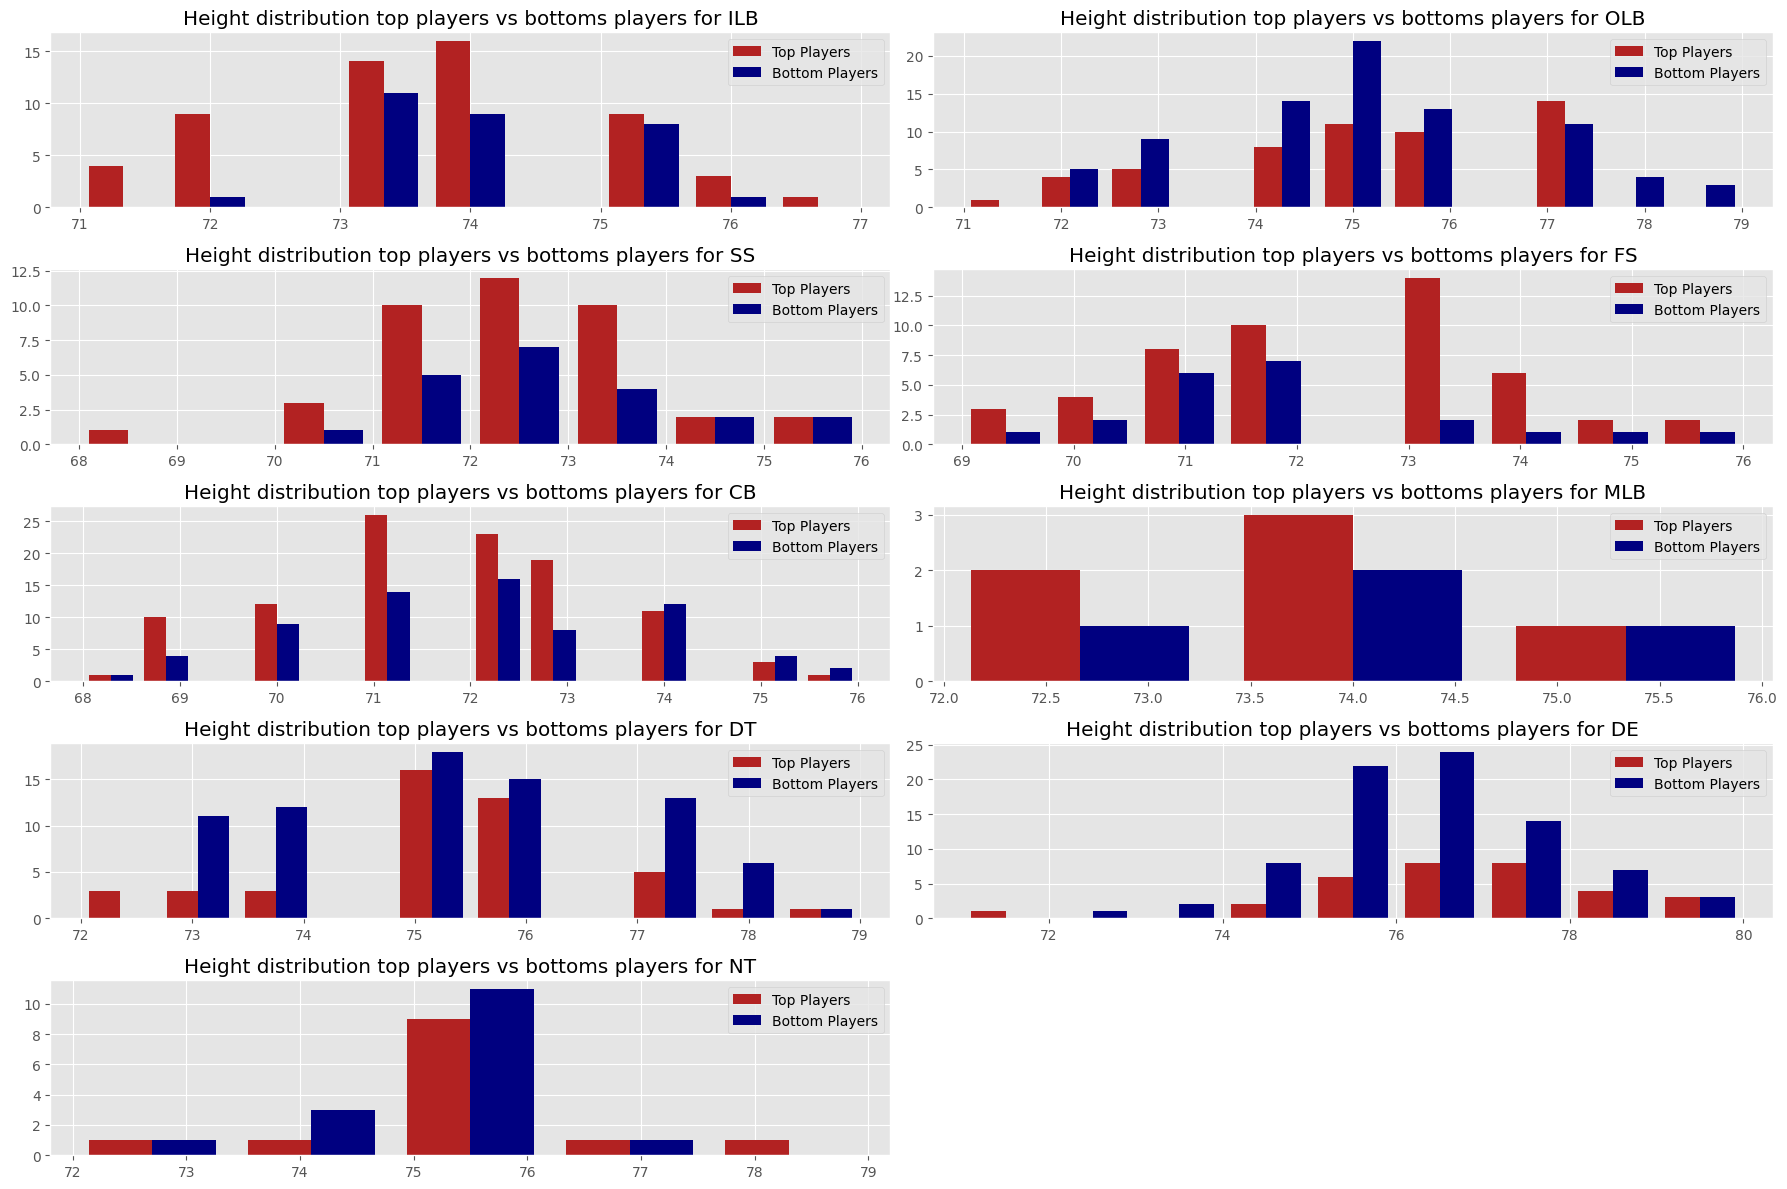

In [103]:
fig = plt.figure(figsize = (18,12))
plt.style.use("ggplot")
colors = ['firebrick', 'navy']
labels = ['Top Players', 'Bottom Players']
for idx, position in enumerate(defensive_positions):
    ax = fig.add_subplot(5,2,idx+1)
    top_df = top_half[top_half['position'] == position]
    bot_df = bot_half[bot_half['position'] == position]
    bins = int(int(top_df.shape[0] ** (1/2)) + int(bot_df.shape[0] ** (1/2))/2) #Take average of shapes, it's recommended that bins are the size of the df, square root of that and rounded up.
    plt.hist([top_df['height'], bot_df['height']], color = colors, bins = bins, label = labels) #Side by side histogram
    ax.legend()
    plt.title(f"Height distribution top players vs bottoms players for {position.upper()}")
plt.tight_layout()
plt.show()

So far it looks like height is pretty uniform between top and bottom players. 

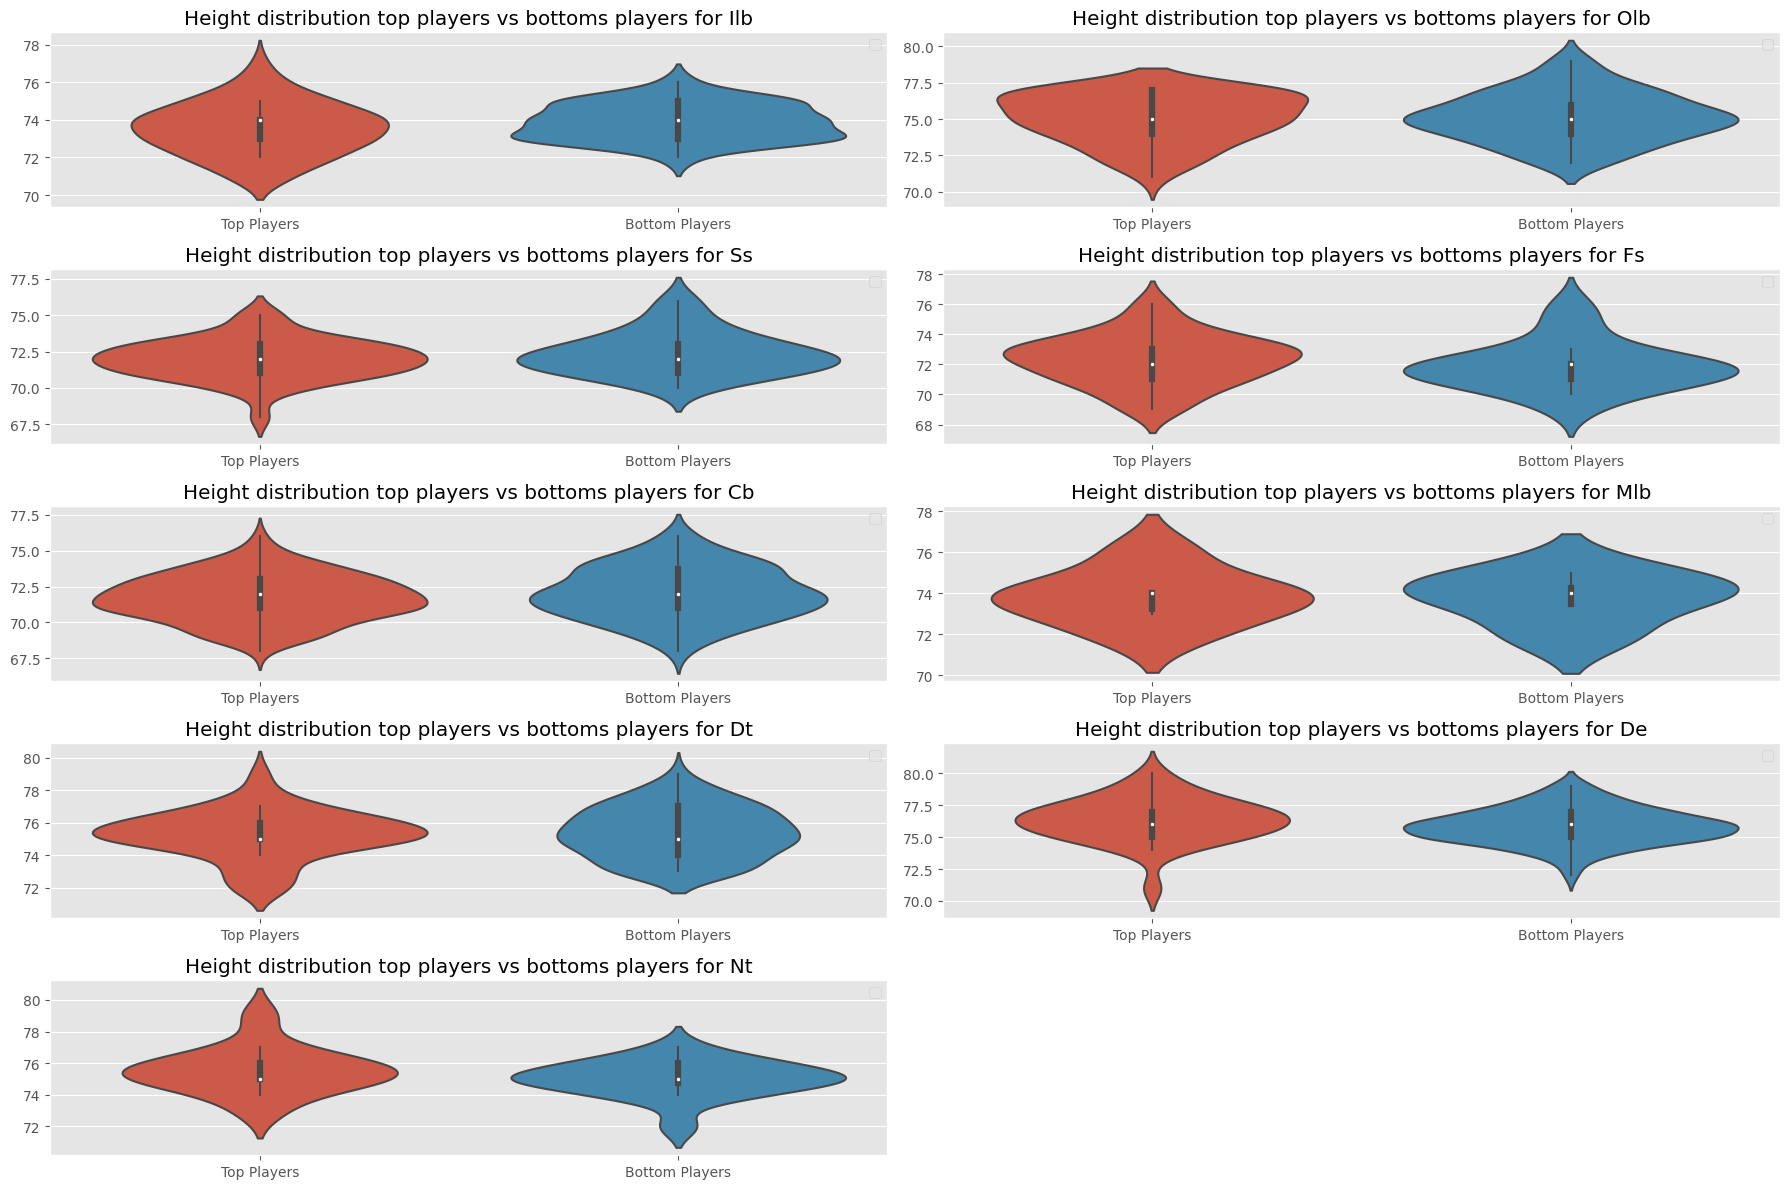

In [104]:
fig = plt.figure(figsize = (18,12))
plt.style.use("ggplot")
colors = ['firebrick', 'navy']
labels = ['Top Players', 'Bottom Players']
for idx, position in enumerate(defensive_positions):
    ax = fig.add_subplot(5,2,idx+1)
    top_df = top_half[top_half['position'] == position]
    bot_df = bot_half[bot_half['position'] == position]
    sns.violinplot([top_df['height'], bot_df['height']]) #Stacked histogram
    ax.legend()
    plt.title(f"Height distribution top players vs bottoms players for {position.title()}")
    plt.xticks(ticks = [0,1], labels = labels)
plt.tight_layout()
plt.show()

Again I don't see much of a difference in distribution of heights, which sort of makes sense. Scouts look for similar profiles in people, physicality does make the image of the player, but skill makes that image come to life. The differences between these players is their experience, intuiton and skill ceiling. 

## P value between average heights and weights

In [105]:
top_half_pos = top_half[['position', 'height', 'weight']]
bot_half_pos = bot_half[['position','height','weight']]

top_average = top_half_pos.groupby("position").mean().reset_index()
bot_average = bot_half_pos.groupby("position").mean().reset_index()
averages = top_average.merge(bot_average, on = "position", suffixes = ("_top", "_bot"))
averages[['position', 'height_top', 'height_bot', 'weight_top', 'weight_bot']]

,position,height_top,height_bot,weight_top,weight_bot
0,CB,71.716981,72.057143,193.415094,192.314286
1,DE,76.343750,75.864198,273.375000,271.432099
2,DT,75.266667,75.381579,308.933333,303.907895
3,FS,72.306122,71.904762,204.551020,201.238095
4,ILB,73.535714,73.900000,235.285714,234.900000
5,MLB,73.833333,73.750000,239.333333,236.750000
6,NT,75.538462,75.000000,319.000000,326.625000
7,OLB,75.075472,75.148148,247.679245,248.024691
8,SS,72.000000,72.380952,202.675000,206.333333


In [106]:
averages['z_score_height'] = averages.apply(lambda x: z_score(x['height_top'], x['height_bot']), axis = 1)
averages['z_score_weight'] = averages.apply(lambda x: z_score(x['weight_top'], x['weight_bot']), axis = 1)

averages['p_value_height'] = scipy.stats.norm.sf(abs(averages['z_score_height']))
averages['p_value_weight'] = scipy.stats.norm.sf(abs(averages['z_score_weight']))

In [107]:
averages[['position', 'p_value_height', 'p_value_weight']]

,position,p_value_height,p_value_weight
0,CB,0.488684,0.477651
1,DE,0.484497,0.466831
2,DT,0.496265,0.419567
3,FS,0.486669,0.434684
4,ILB,0.488033,0.492904
5,MLB,0.497263,0.452877
6,NT,0.482497,0.382055
7,OLB,0.497634,0.493810
8,SS,0.487354,0.428227


We see that in terms of height almost all are .48-.49 in p value, which indicates no difference in population. Regarding weight, there is a bit more variation, we see the lowest p values in DT, MLB and NT, meaning these positions have the largest difference in average weight. 

Regardless of the reason for this, we can safely say there isn't a large difference in weights and heights of the most efficient and inefficient defensive players.

# Clustering

I wanted to add in some clustering in an attempt to identify segments of players. I thought I should focus on a single position to add some specificity, therefore I isolated cornerbacks since they had one of the highest counts of players across the dataframe. 

In [108]:
combined_tackles

,displayName,nflId,height,weight,collegeName,position,tackle_contribution,pff_missedTackle,total_plays,efficiency %
0,A'Shawn Robinson,43335,6-4,330,Alabama,DT,34,3,37,92.0
1,A.J. Epenesa,52462,6-5,280,Iowa,DE,2,5,7,29.0
2,A.J. Klein,40096,6-1,240,Iowa State,OLB,4,2,6,67.0
3,A.J. Parker,53957,5-11,178,Kansas State,CB,12,0,12,100.0
4,A.J. Terrell,52424,6-2,190,Clemson,CB,28,8,36,78.0
...,...,...,...,...,...,...,...,...,...,...
795,Zack Baun,52482,6-3,235,Wisconsin,OLB,2,1,3,67.0
796,Zaire Franklin,46304,6-0,236,Syracuse,OLB,83,12,95,87.0
797,Zaven Collins,53445,6-4,260,Tulsa,OLB,64,13,77,83.0
798,Zech McPhearson,53552,5-11,195,Texas Tech,CB,2,0,2,100.0


In [109]:
cluster_data = combined_tackles[['displayName', 'height', 'weight', 'position', 'tackle_contribution', 'total_plays', 'efficiency %']]
cluster_data['height'] = cluster_data.apply(calc_height, axis = 1)

In [110]:
corner_backs = cluster_data[cluster_data['position'] == "CB"].drop(columns = "position")

We can now do an elbow plot to identify how many clusters to use. This method is a heuristic that identifies the variance explained across an increasing number of clusters. It is called an "elbow" plot because we choose a k where the variance starts to level off and an increasing number of clusters is not needed to lower the variance by a significant amount. 

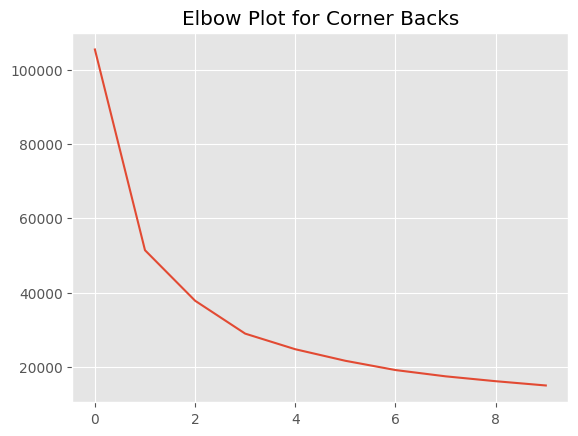

In [111]:
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(corner_backs.iloc[:, 1:]) 
    wcss.append(kmeans.inertia_)
    
plt.plot(wcss)
plt.title("Elbow Plot for Corner Backs")
plt.show()

In [112]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
y_kmeans = kmeans.fit_predict(corner_backs.iloc[:, 1:])
corner_backs['cluster'] = y_kmeans

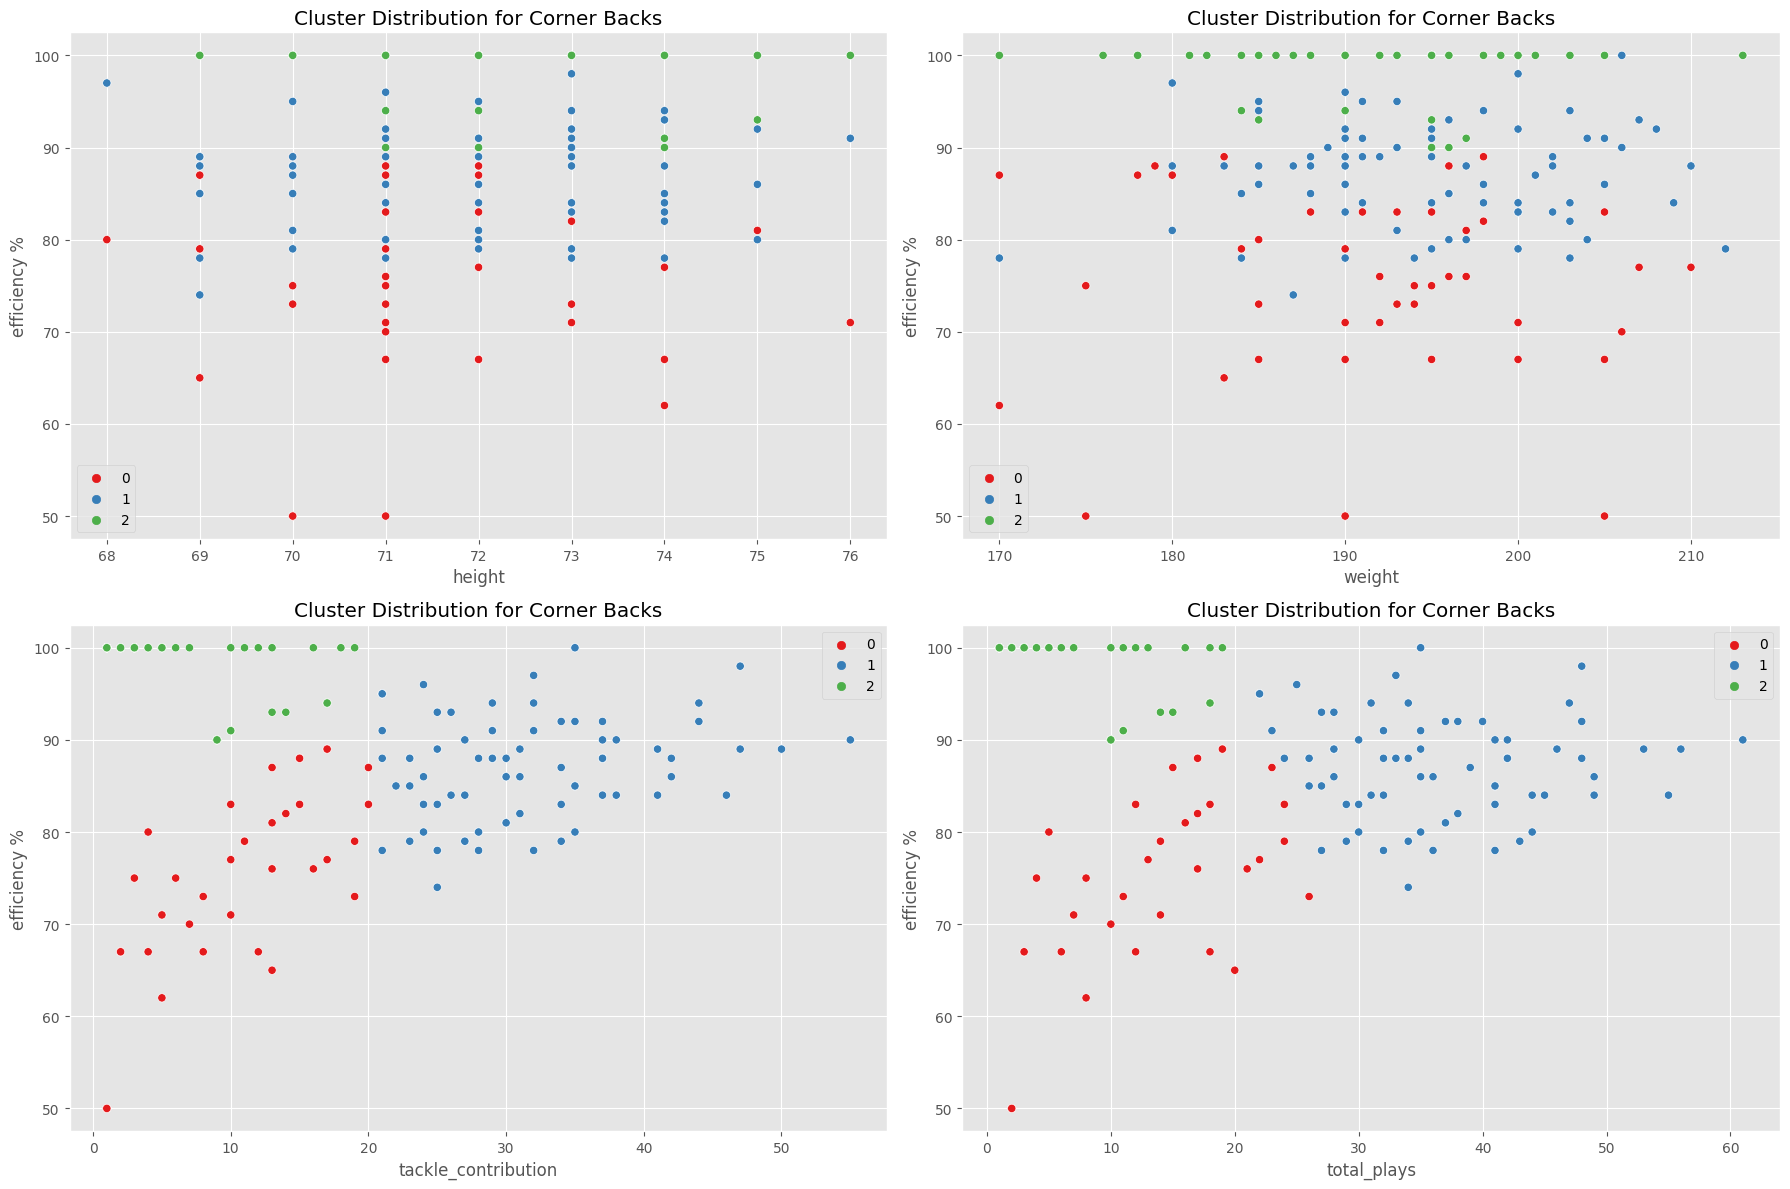

In [113]:
fig = plt.figure(figsize = (18,12))
np.random.seed(0)
for idx, column in enumerate(list(corner_backs.columns)[1:]):
    if column == "cluster" or column == "efficiency %":
        continue
    ax = fig.add_subplot(2,2,idx+1)
    sns.scatterplot(data = corner_backs, x = column, y = 'efficiency %', hue = "cluster", palette = "Set1")
    plt.xlabel(column)
    plt.ylabel("efficiency %")
    plt.title(f"Cluster Distribution for Corner Backs")
    plt.legend()
plt.tight_layout()
plt.show()

We see that the green cluster seems to be the most played corner backs with moderate to high efficiency. These are the players that get targeted frequently, play a lot or get heavily involved and do pretty well. The red cluster is the group of players that play less, get targeted less or aren't as competitive and have subpar efficiency. The blue group is those that get targeted less, maybe contribute less, but they are very efficient when needed. * Notice that the contribution % is higher than 100 since plays could count as a tackle and a fumble, I think this is fair since it shows they are contributing more than just a tackle. 

When it comes to height and weight, it seems that every cluster has a wide spread of heights and weights, which reinforces my point that there isn't a clear distinction across nfl players in terms of weights and heights. 

Now I'll look at what players are in these clusters and see if they match what I just said in the previous text box. 

Top players we'll be looking for, according to [pff for 2022](https://www.pff.com/news/nfl-final-2022-cornerback-rankings) are:
- Sauce Gardner
- Patrick Surtain
- James Bradberry
- Jaire Alexander
- Stephon Gilmore
- Tyson Campbell
- Patrick Peterson
- Charvarius Ward
- Jalen Ramsey
- DJ Reed

In [114]:
for player in ['Ahmad Gardner', 'Patrick Surtain', 'James Bradberry', 'Jaire Alexander', 'Stephon Gilmore', 'Tyson Campbell', 'Patrick Peterson', 'Charvarius Ward', 'Jalen Ramsey', 'D.J. Reed']:
    display(corner_backs[corner_backs['displayName'] == player])

,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
14,Ahmad Gardner,75,200,44,48,92.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
633,Patrick Surtain,74,203,27,32,84.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
353,James Bradberry,73,212,23,29,79.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
339,Jaire Alexander,70,196,23,27,85.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
709,Stephon Gilmore,73,202,31,35,89.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
769,Tyson Campbell,74,185,42,48,88.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
631,Patrick Peterson,73,203,29,31,94.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
135,Charvarius Ward,73,195,35,35,100.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
347,Jalen Ramsey,73,208,34,37,92.0,1


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
172,D.J. Reed,69,188,41,46,89.0,1


As suspected, cluster 1 seems to be the group with majority of the premier corner backs in the league. Let's look at that cluster to identify some names that aren't in the pff link. These could be players that had a stellar season or may be a rising consistent star. 

In [115]:
cluster_1 = corner_backs[corner_backs['cluster'] == 1].sort_values(by = ['total_plays', 'efficiency %'], ascending = False).reset_index(drop = True)
cluster_1.head(32)

,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
0,L'Jarius Sneed,73,193,55,61,90.0,1
1,Roger McCreary,72,188,50,56,89.0,1
2,Kyler Gordon,72,195,46,55,84.0,1
3,Taron Johnson,71,192,47,53,89.0,1
4,Adoree' Jackson,71,185,42,49,86.0,1
5,Coby Bryant,73,198,41,49,84.0,1
6,Jeff Okudah,73,200,47,48,98.0,1
7,Ahmad Gardner,75,200,44,48,92.0,1
8,Tyson Campbell,74,185,42,48,88.0,1
9,Cameron Dantzler,74,185,44,47,94.0,1


I filtered by more than 30 possible tackles to target players that get more action and are still performing at a high level. 

Pff lists the top 32 corner backs in the league each year, so I displayed the top 32. Out of 32 players here, 13 aren't on either 2022's pff nor [2023 pff](https://www.pff.com/news/nfl-cornerback-rankings-final-sauce-gardner-retains-his-place-as-the-no-1-cornerback-in-the-nfl) (I didn't include Chidobe because Pff mentioned he would be ranked if he had more plays, he was injured in 2022): 
- Kyler Gordon (2nd year)
- Coby Bryant (2nd year)
- Jeff Okudah (4th year) 
- Cameron Dantzler (4th year) 
- Marco Wilson (3rd year) 
- Anthony Brown (8th year) 
- Kristian Fulton (4th year)
- Nate Hobbs (3rd year) 
- Chidobe Awuzie \* (7th year) 
- Michael Jackson (5th year) 
- Carlton Davis (6th year)
- Kaiir Elam (2nd year)
- Byron Murphy (5th year) 
- Amani Oruwariye (5th year)

\* means they were an honorable mention

Therefore 19 out of 32, almost 60% of players here are among the top cornerbacks in the league.

Also, given that corner backs typically last [only 3 years in the league](https://www.statista.com/statistics/240102/average-player-career-length-in-the-national-football-league/) we see the players that aren't on pff could be considered exceptional as well, since out of 11 out of 13 have been in the league for at least 3 years. The two players who aren't in this: **Kyler Gordon, Coby Bryant**; could be some names to look out for in the next few years. 

Also, there are **6** players not listed on 2022's Pff but do exist on the 2023 Pff list. Meaning, this method could be useful in targeting players that have potential to be amongst the top corner backs in the league:
- Roger McCreary (4th year) 
- Kenny Moore (7th year) (1x Pro-Bowl)
- Mike Hilton (7th year)
- Derek Stingley (2nd year)
- Donte Jackson (6th year)
- Paulson Adebo (3rd year)

The dimensions across the clusters is a bit large in difference:
- Cluster 0: 44
- Cluster 1: 82
- Cluster 2: 50

So let's try using 4 clusters to see if there's any more segmentation and balanced cluster dimensions.

In [116]:
corner_backs_2 = cluster_data[cluster_data['position'] == "CB"].drop(columns = "position")

kmeans = KMeans(n_clusters = 4, random_state = 42)
y_kmeans = kmeans.fit_predict(corner_backs.iloc[:, 1:])
corner_backs_2['cluster'] = y_kmeans

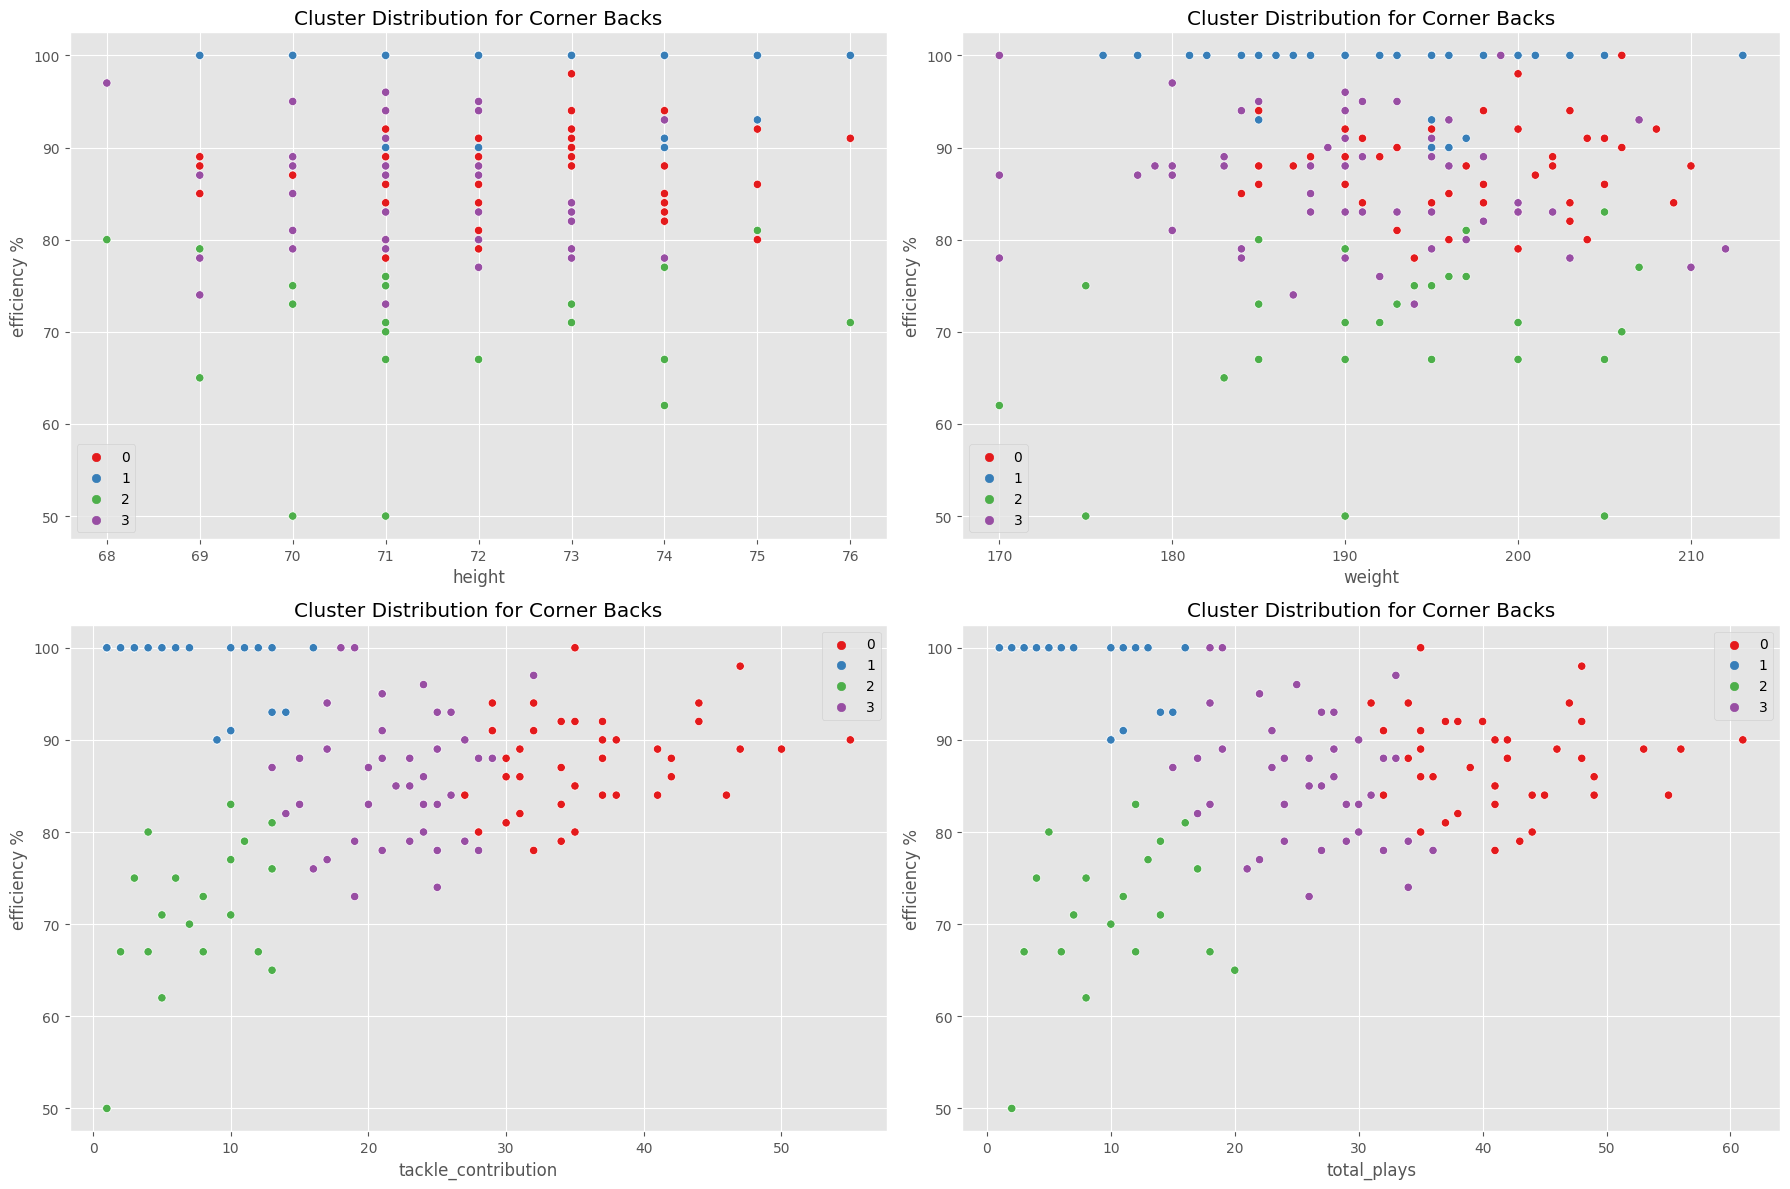

In [117]:
fig = plt.figure(figsize = (18,12))
np.random.seed(0)
for idx, column in enumerate(list(corner_backs_2.columns)[1:]):
    if column == "cluster" or column == "efficiency %":
        continue
    ax = fig.add_subplot(2,2,idx+1)
    sns.scatterplot(data = corner_backs_2, x = column, y = 'efficiency %', hue = "cluster", palette = "Set1")
    plt.xlabel(column)
    plt.ylabel("efficiency %")
    plt.title(f"Cluster Distribution for Corner Backs")
    plt.legend()
plt.tight_layout()
plt.show()

In [118]:
for player in ['Ahmad Gardner', 'Patrick Surtain', 'James Bradberry', 'Jaire Alexander', 'Stephon Gilmore', 'Tyson Campbell', 'Patrick Peterson', 'Charvarius Ward', 'Jalen Ramsey', 'D.J. Reed']:
    display(corner_backs_2[corner_backs_2['displayName'] == player])

,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
14,Ahmad Gardner,75,200,44,48,92.0,0


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
633,Patrick Surtain,74,203,27,32,84.0,0


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
353,James Bradberry,73,212,23,29,79.0,3


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
339,Jaire Alexander,70,196,23,27,85.0,3


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
709,Stephon Gilmore,73,202,31,35,89.0,0


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
769,Tyson Campbell,74,185,42,48,88.0,0


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
631,Patrick Peterson,73,203,29,31,94.0,0


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
135,Charvarius Ward,73,195,35,35,100.0,0


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
347,Jalen Ramsey,73,208,34,37,92.0,0


,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
172,D.J. Reed,69,188,41,46,89.0,0


In [119]:
cluster_0 = corner_backs_2[corner_backs_2['cluster'] == 0].sort_values(by = ['total_plays', 'efficiency %'], ascending = False).reset_index(drop = True)
cluster_0.tail(10)

,displayName,height,weight,tackle_contribution,total_plays,efficiency %,cluster
35,Stephon Gilmore,73,202,31,35,89.0,0
36,Benjamin St-Juste,75,205,30,35,86.0,0
37,Shaquill Griffin,72,198,30,35,86.0,0
38,Jaylen Watson,75,204,28,35,80.0,0
39,Kendall Fuller,71,198,32,34,94.0,0
40,Marlon Humphrey,72,197,30,34,88.0,0
41,Fabian Moreau,72,204,29,32,91.0,0
42,Tariq Woolen,76,205,29,32,91.0,0
43,Patrick Surtain,74,203,27,32,84.0,0
44,Patrick Peterson,73,203,29,31,94.0,0


In [120]:
corner_backs_2[corner_backs_2['cluster'] == 0].shape

(45, 7)

It seems like we see a lot of familiar names across the PFF list, but I won't go in depth into this list as I did with the other. I do think this is. The dimensions across clusters are as follows (maybe a bit more balanced?):
- Cluster 0: 45 players
- Cluster 1: 46 players
- Cluster 2: 27 players
- Cluster 3: 58 players

# Conclusion
The question we were attempting to answer with this data was if there was a physical difference, in terms of heights and weights, across the top defensive performers and bottom performers per position. We saw there was no significant difference in physical heights and weights across positions but there was a significance in number of players in top efficiency vs bottom efficiency in certain positions. These positions were *defensive end* and *free safety*. 

I then did clustering for a bit of fun and found that it could be used to identify corner backs that are in the same realm as the top players at that position. This could be a fun thing to check up on each year and see if it's accurate. 
    